# Brief
The Cincinnati Police Department is investigating to see if their officers are exhibiting any unconscious biases in carrying out traffic stops while out on patrol. Using the data available from the Stanford Open Policing Project, analyze the stops that CPD officers made and provide visualizations that give perspective to see if further investigation into unconscious biases is warranted.

In [ ]:
# First let's import the packages we will use in this project
# You can do this all now or as you need them
import pandas as pd
import geopandas as gpd
import folium
from folium import Choropleth
from folium.plugins import HeatMap
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None



# Now we need to read in the data
df = pd.read_csv('/kaggle/input/cincohstopdata-dec2008may2018/CincOHStopData_Dec2008-May2018.csv')
print(df.columns)
df

# Data Cleaning

In [285]:
# Checking for null data
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

raw_row_number - 0%
date - 0%
time - 0%
location - 0%
lat - 0%
lng - 0%
neighborhood - 81%
beat - 76%
subject_race - 0%
subject_sex - 0%
officer_assignment - 2%
type - 0%
disposition - 75%
arrest_made - 0%
citation_issued - 0%
warning_issued - 0%
outcome - 19%
reason_for_stop - 88%
vehicle_make - 1%
vehicle_model - 1%
vehicle_registration_state - 1%
vehicle_year - 1%
raw_race - 0%
raw_action_taken_cid - 0%
raw_field_subject_cid - 0%


In [286]:
df1 = df[['raw_row_number','date','time','lat','lng','subject_race','subject_sex','officer_assignment','type','arrest_made',
         'citation_issued','warning_issued','vehicle_make','vehicle_model','vehicle_registration_state','vehicle_year','raw_race',
         'raw_action_taken_cid','raw_field_subject_cid']]
for col in df1.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))
df = df1

raw_row_number - 0%
date - 0%
time - 0%
lat - 0%
lng - 0%
subject_race - 0%
subject_sex - 0%
officer_assignment - 2%
type - 0%
arrest_made - 0%
citation_issued - 0%
warning_issued - 0%
vehicle_make - 1%
vehicle_model - 1%
vehicle_registration_state - 1%
vehicle_year - 1%
raw_race - 0%
raw_action_taken_cid - 0%
raw_field_subject_cid - 0%


In [287]:
# Maniuplating the subject_race & subject_sex attribute for visualization later
df['subject_race'] = df['subject_race'].str.replace('white', "White")
df['subject_race'] = df['subject_race'].str.replace('black', "Black")
df['subject_race'] = df['subject_race'].str.replace('other', "Other")
df['subject_race'] = df['subject_race'].str.replace('hispanic', "Other")
df['subject_race'] = df['subject_race'].str.replace('unknown', "Other")
df['subject_race'] = df['subject_race'].str.replace('asian/pacific islander', "Other")

df['subject_sex'] = df['subject_sex'].str.replace('male','Male')
df['subject_sex'] = df['subject_sex'].str.replace('feMale','Female')

In [288]:
# Removing redundent seconds data that isn't actually tracked
df['time'] = df['time'].str.slice(0,-3)
df['time'].head()

0    01:16
1    22:00
2    13:50
3    08:21
4    15:03
Name: time, dtype: object

# Data Visualizations

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


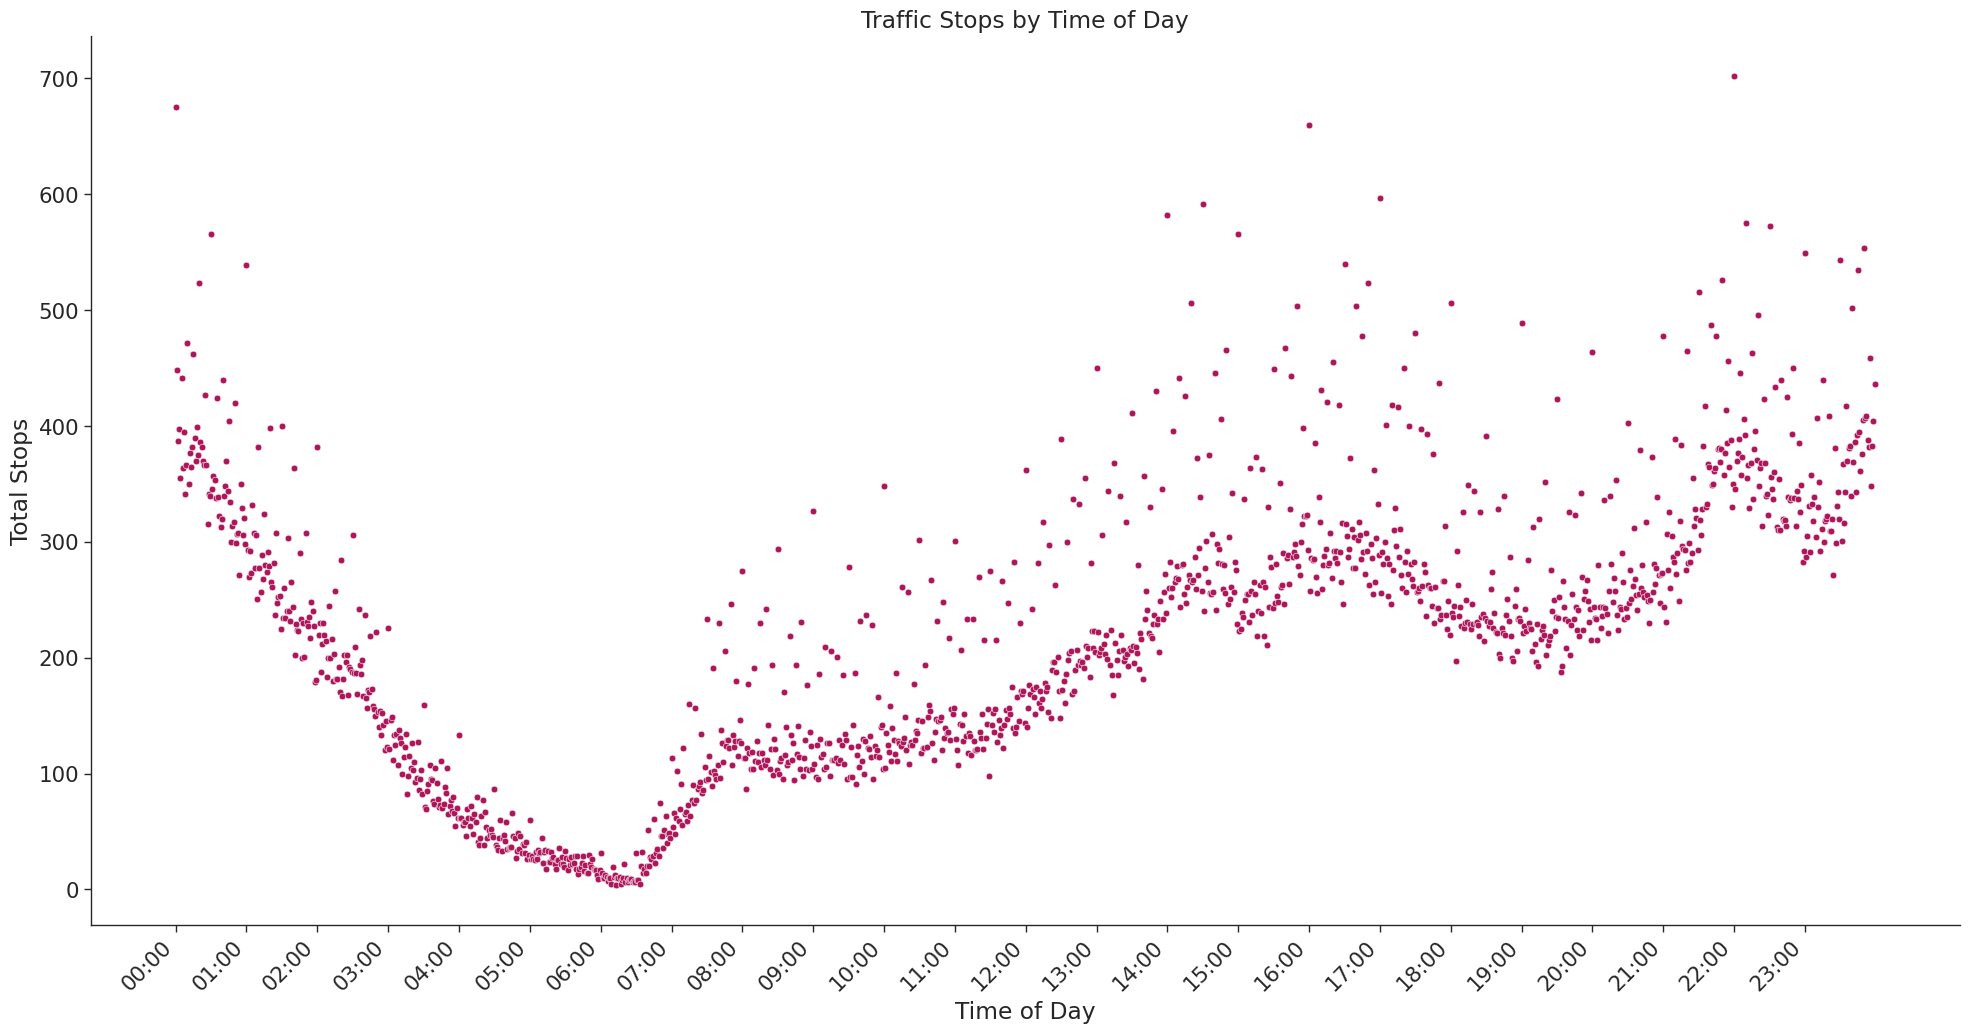

In [289]:
# Figure 1: Total Stops by Time of Day
fig1_data = df[['time']]
fig1_data = fig1_data.groupby('time').value_counts().reset_index(name = 'stop_counts')

sns.set_theme(context='paper', style='ticks', font_scale=1.75)
fig1=sns.relplot(data = fig1_data,
                 x="time",
                 y="stop_counts",
                 height=10,aspect=2,
                 color=sns.color_palette('rocket')[2]
                )

fig1.ax.set_xticks(['00:00','01:00','02:00','03:00','04:00','05:00','06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00'])
fig1.set_axis_labels('Time of Day','Total Stops')
fig1.ax.set_xticklabels(fig1.ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title("Traffic Stops by Time of Day")
plt.show()

# Traffic Stops by Time of Day
For some foundational perspective, traffic stops have the tendency to follow trends throughout the day that align with different events that occur within the same windows:

* Stops are at their peak from 21:00 - 00:00 (9pm - midnight), after which their is a steady decline with outlier high times that could possibly correlate with people leaving bars and driving home while intoxicated, or there at least being some presumption of the possibility causing officers to be more ready to pull-over
* Sharp decline from 04:00 - 06:00, followed by a large spike following the 6:30 marker, correlating with both times where people are less likely to be out in public following last call as well as the approach to end of shift at the 06:30 marker. This also shows a possible connection with the new shift of officers starting their day, as there is a faster increase in stops as officers are leaving the station and going to their beats while also monitoring the morning commute of people into work
* Things remain mostly steady with a slight upward trend before things level out at a higher number from 14:00 - 16:00 with rush hour, followed by a slight dropoff that could possibly be correlated with an increase in 911/non-emergency call volume from people returning home from the workday

This graph of general stop volume provides perspective to the below when looking into the distribution of who is being stopped and at what time of the day.

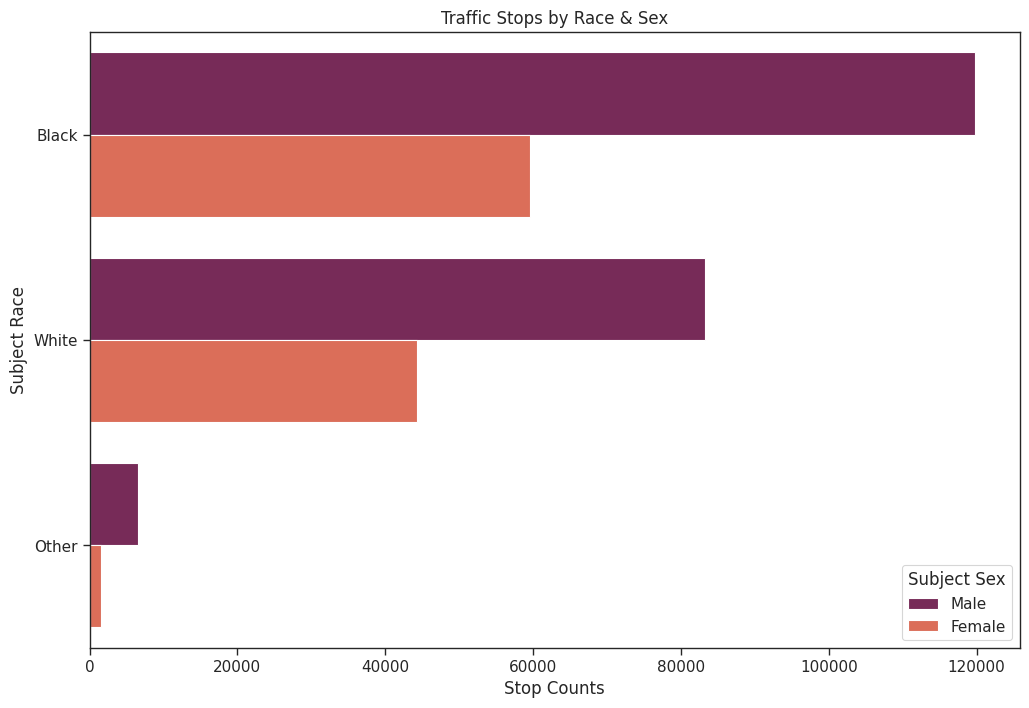

In [290]:
# Figure 2: Stops by Subject Sex & Race
fig2_data = df[['subject_race','subject_sex']]
fig2_data.rename(columns = {'subject_race':'Subject Race','subject_sex':'Subject Sex'}, inplace = True)

fig2_data = fig2_data.groupby('Subject Race').value_counts().reset_index(name='Stop Counts').sort_values('Stop Counts',ascending=False)

sns.set_theme(context='paper', style='ticks', font_scale=1.25)
fig2 = sns.barplot(data = fig2_data,
                   y="Subject Race",
                   x="Stop Counts",
                   hue='Subject Sex',
                   palette='rocket',
                  )
plt.title("Traffic Stops by Race & Sex")
plt.show()

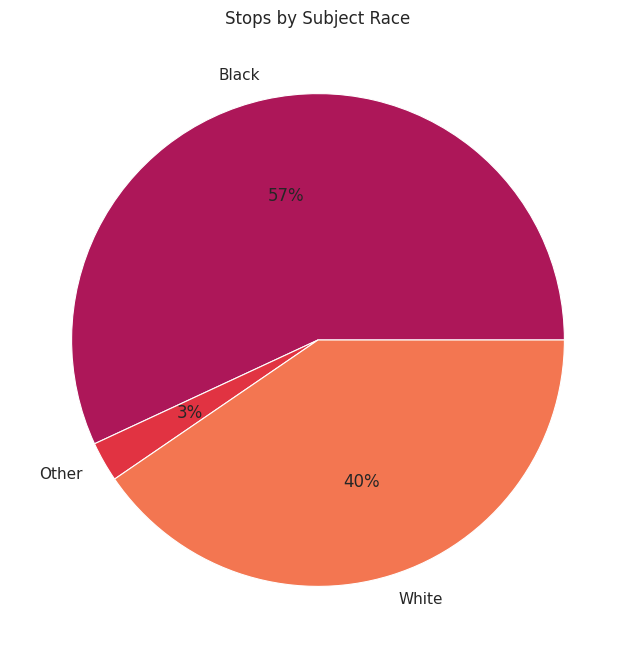

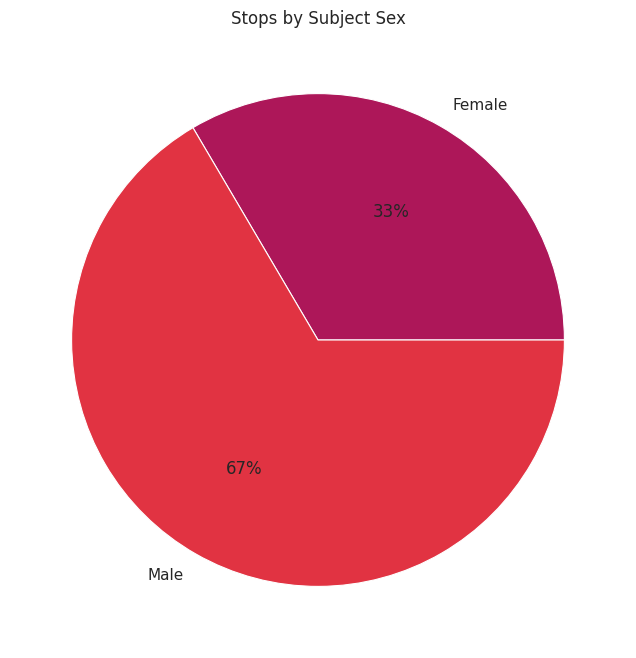

In [291]:
# Figure 2.5: Individual Breakdown by Race & Sex
fig_race_data = df[['subject_race']]
fig_race_data = fig_race_data.groupby('subject_race').value_counts().reset_index(name='stop_counts')

fig_race = plt.pie(fig_race_data['stop_counts'],
                   labels=fig_race_data['subject_race'],
                   colors=sns.color_palette('rocket')[2:],
                   autopct='%.0f%%'
                  )
plt.title('Stops by Subject Race')
plt.show()

fig_sex_data = df[['subject_sex']]
fig_sex_data = fig_sex_data.groupby('subject_sex').value_counts().reset_index(name='stop_counts')

fig_sex = plt.pie(fig_sex_data['stop_counts'],
                  labels=fig_sex_data['subject_sex'],
                  colors=sns.color_palette('rocket')[2:],
                  autopct='%.0f%%'
                  )
plt.title('Stops by Subject Sex')
plt.show()

# Traffic Stops by Race & Sex
As the above charts outline, there is quite a large discrepancy when it comes to overall counts of traffic stops of **Black subjects** compared to any other race. Men are roughly **50% more likely** to be pulled over than females are of the same race, and more than **65% more likely** to be pulled over than women in general, making **Black men** by far and away the most likely group of people to be pulled over by CPD officers in the timespan that this data illustrates.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


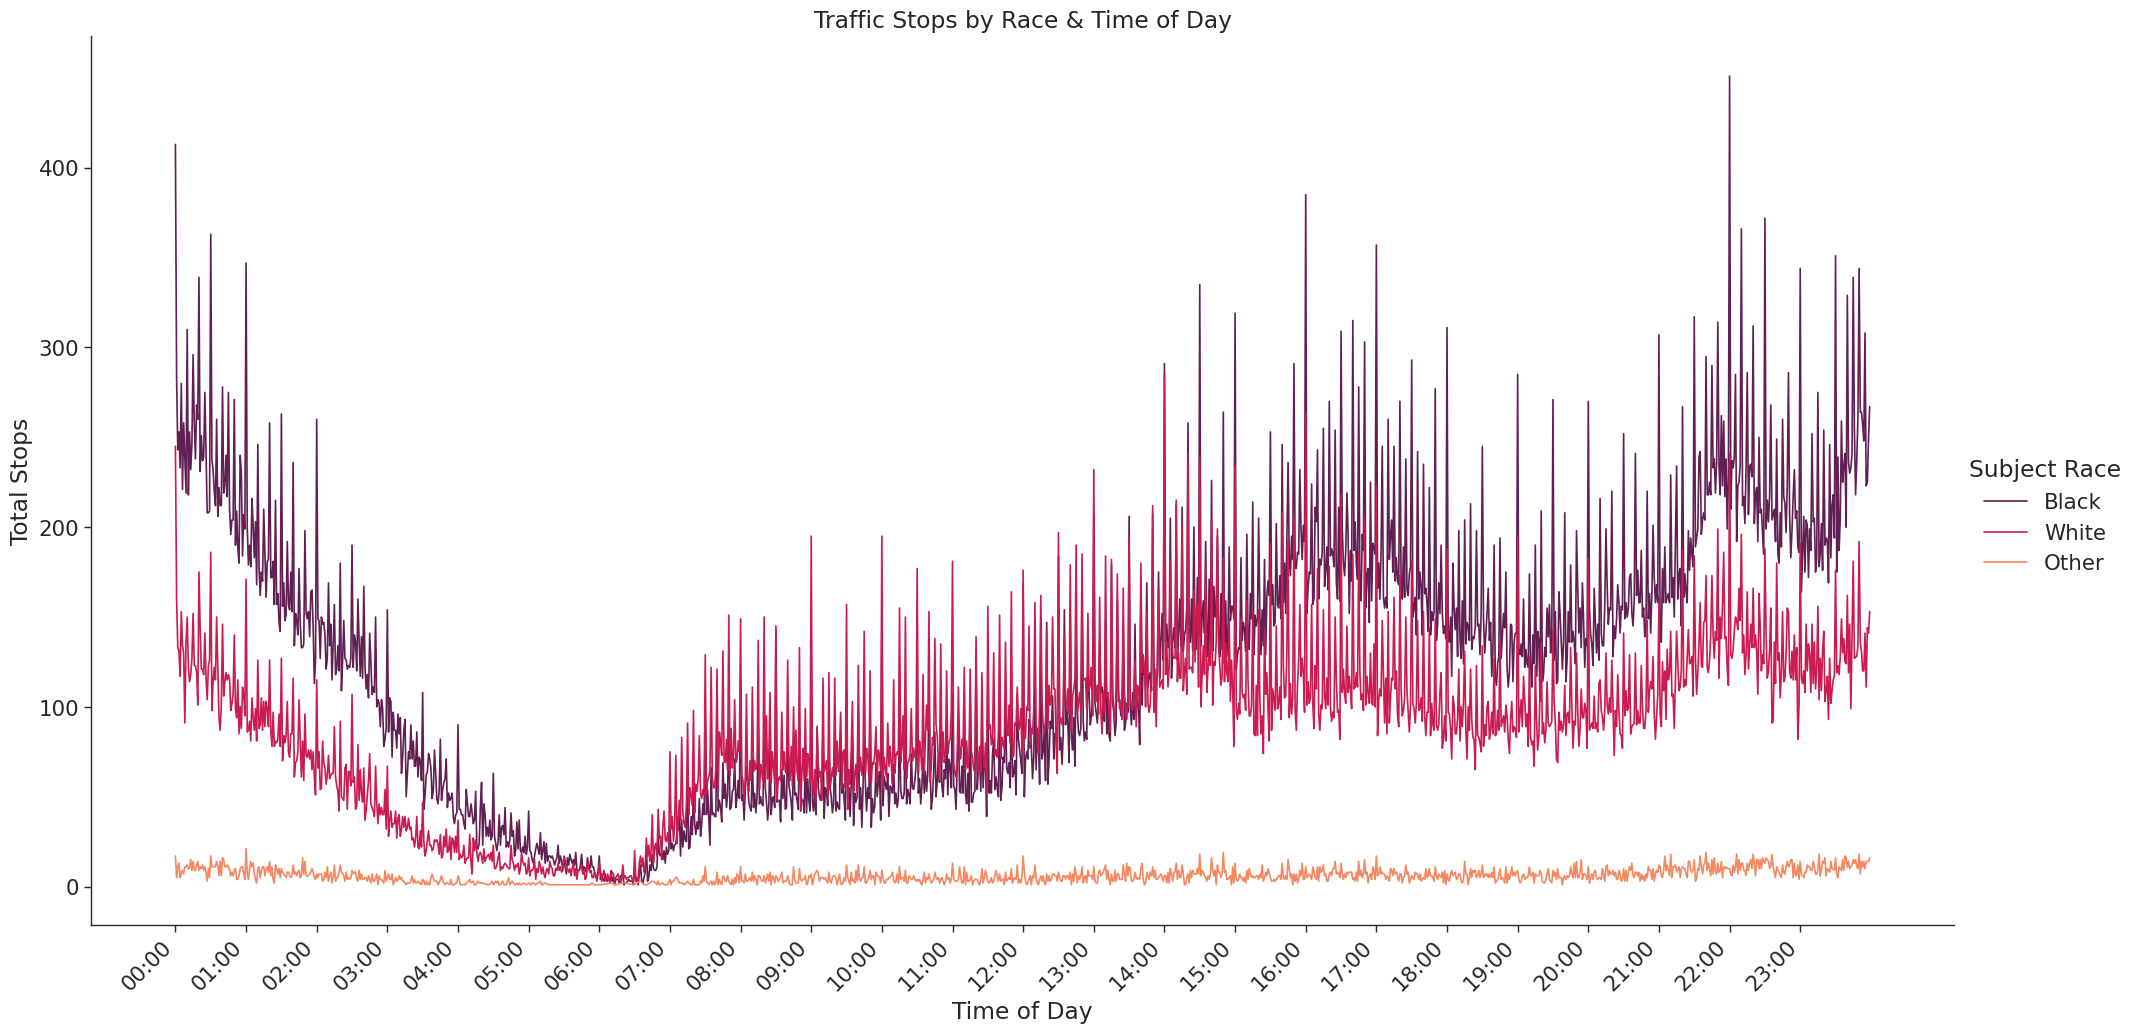

In [292]:
# Figure 3: Total Stops by Race & Time of Day
fig3_data = df[['time','subject_race']]
fig3_data = fig3_data.groupby('time')['subject_race'].value_counts().reset_index(name = 'stop_counts')

sns.set_theme(context='paper', style='ticks', font_scale=1.75)
fig3=sns.relplot(data = fig3_data, kind='line',
                 x="time",
                 y="stop_counts",
                 hue='subject_race',
                 height=10,aspect=2,
                 palette='rocket'
                )

fig3.ax.set_xticks(['00:00','01:00','02:00','03:00','04:00','05:00','06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00'])
fig3.set_axis_labels('Time of Day','Total Stops')
fig3.legend.set_title('Subject Race')
fig3.ax.set_xticklabels(fig3.ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title("Traffic Stops by Race & Time of Day")
plt.show()

# Traffic Stops by Race & Time of Day
After combining the information from figures 1 and 2, the spread of who is getting pulled over throughout the day can be seen here. Apart from the sharp decline seen from about **02:00 - 06:30**, **White subjects** maintain a mostly constant representation of traffic stop counts throughout the day from about **07:30 - 00:00**. The same cannot be said for **Black subjects**, who experience slightly less overall traffic stops than White subjects *(still being pulled over at a higher rate on a percentage-base when looking at the race distribution of Cincinnati's populous)* until the overall number **increases drastically following 14:30**. The divide remains or increases until about **01:00**, but declines much slower than it does for White subjects.

The spikes in traffic stops being made throughout the day are not correlated with an increase in overall traffic stops entirely when taking figures 1 and 3 together. The burden of increased traffic stops are almost solely lying with the increase in stops being made **specifically involving Black subject**.

In [293]:
# Creating point geometries
geometry = gpd.points_from_xy(df['lng'],df['lat'])
df['date_time'] = df.apply(lambda x:'%s %s' % (x['date'],x['time']),axis=1)
df['date_time'] = pd.to_datetime(df['date_time'])

geo_df = gpd.GeoDataFrame(df[['date_time','lat','lng','subject_race','subject_sex','officer_assignment','type','arrest_made','citation_issued',
                              'warning_issued','vehicle_make','vehicle_model','vehicle_registration_state','vehicle_year','raw_action_taken_cid']],geometry=geometry)

geo_df

date_time        lat        lng subject_race subject_sex  \
0      2010-02-05 01:16:00  39.152585 -84.541274        White      Female   
1      2010-06-25 22:00:00  39.125240 -84.548137        Black        Male   
2      2011-04-10 13:50:00  39.181386 -84.566705        White        Male   
3      2009-07-27 08:21:00  39.125902 -84.533075        White        Male   
4      2010-06-09 15:03:00  39.109634 -84.514849        Black        Male   
...                    ...        ...        ...          ...         ...   
315276 2011-10-27 11:57:00  39.182174 -84.407973        Black        Male   
315277 2012-02-06 17:20:00  39.165824 -84.469602        White      Female   
315278 2013-04-06 21:13:00  39.100442 -84.521330        White      Female   
315279 2009-01-08 18:04:00  39.119713 -84.517104        Black        Male   
315280 2012-04-21 00:17:00  39.145210 -84.619970        White        Male   

       officer_assignment       type arrest_made citation_issued  \
0              DISTRICT 3  vehicular        True            True   
1                     NaN  vehicular       False            True   
2             CANINE UNIT  vehicular       False           False   
3              DISTRICT 1  vehicular       False           False   
4                  VORTEX  vehicular       False           False   
...                   ...        ...         ...             ...   
315276         DISTRICT 2  vehicular       False           False   
315277         DISTRICT 4  vehicular        True            True   
315278       TRAFFIC UNIT  vehicular       False            True   
315279         DISTRICT 1  vehicular       False           False   
315280         DISTRICT 3  vehicular       False           False   

       warning_issued vehicle_make vehicle_model vehicle_registration_state  \
0               False         CHRY          VOYA                         OH   
1               False         DODG          CARA                         OH   
2               False         NISS          ALTI                         OH   
3                True         CHEV          CAVA                         OH   
4               False         MAZD             3                         OH   
...               ...          ...           ...                        ...   
315276          False         CHEV          TRUC                         OH   
315277          False         JEEP          CHER                         OH   
315278          False         HOND          CIVI                         OH   
315279           True         CADI          DEVI                         OH   
315280          False         CHEV          CAVA                         OH   

        vehicle_year                  raw_action_taken_cid  \
0             2002.0    CITATION TRAFFIC|ARREST CAPIAS/WAR   
1             1999.0                      CITATION TRAFFIC   
2             1996.0                            WARNING|NA   
3             1999.0                               WARNING   
4             2010.0                                  NONE   
...              ...                                   ...   
315276        1994.0                            NA|WARNING   
315277        2004.0  NA|ARREST CAPIASWAR|CITATION TRAFFIC   
315278        2012.0                      CITATION TRAFFIC   
315279        1995.0                               WARNING   
315280        2003.0                               NA|NONE   

                          geometry  
0       POINT (-84.54127 39.15258)  
1       POINT (-84.54814 39.12524)  
2       POINT (-84.56671 39.18139)  
3       POINT (-84.53307 39.12590)  
4       POINT (-84.51485 39.10963)  
...                            ...  
315276  POINT (-84.40797 39.18217)  
315277  POINT (-84.46960 39.16582)  
315278  POINT (-84.52133 39.10044)  
315279  POINT (-84.51710 39.11971)  
315280  POINT (-84.61997 39.14521)  

[315281 rows x 16 columns]

In [294]:
map_lat = 39.13
map_lng = -84.52

In [296]:
map = folium.Map(location=[map_lat, map_lng], zoom_start=13, tiles="CartoDB positron")

arrest_geo = geo_df.loc[geo_df['arrest_made'] == True].dropna()
HeatMap(arrest_geo[['lat','lng']],
        radius=2.25,blur=2
       ).add_to(folium.FeatureGroup(name='Arrest Heat Map').add_to(map))

citation_geo = geo_df.loc[geo_df['citation_issued'] == True].dropna()
HeatMap(citation_geo[['lat','lng']],
        radius=2,blur=2
       ).add_to(folium.FeatureGroup(name='Citation Heat Map').add_to(map))

folium.LayerControl().add_to(map)
map

# Traffic Stop Distribution
The purpose of this map is to show the distribution of where traffic stops were made using the latitude/longitude data provided by the dataset to see where hot and cold spots are throughout the city's jurisdiction:
* Unsurprisingly, there is a general hotspot in the center of city limits, especially surrounding Heritage Bank Center, Great American Ballpark, and the Duke Energy Convention Center where there are often large collections of people
* The cold spot stretching through the center of the city is due to rail lines where there are no roads to perform traffic stops on
* Consolidation of hot spots can be seen along the state routes, interstates, and other major roadways in and out of the city recieving increased traffic and police attention
* Along with the more typically expected hot spots, communities that are historically known to be low-income, and majority-Black-population like Price Hill (especially Lower Price Hill), Over the Rhine, Avondale, and Fairmount show a much higher ammount of police activity along with clusters of stops in low-income housing/apartment complexes like the Fay Apartments and Stanley Rowe Towers

# Final Thoughts
The above data visualizations show that there is reason for further investigation into the situation for potential unconscious bias. That being said, no conclusions can be drawn directly from this data as there are innumerable confounding variables potentially at play in the situation as well. The above visualizations are important resources to providing perspective and opening the door to asking more questions about the policies and habits that have been encouraged for areas/individuals for officers to prioritize stops for while out on patrol.

The heatmap specifically also shows potential areas that would benefit from investment into the wellbeing of these communities beyond increased police presence.